
# Generic Sampling Approach for Time Series
---
This notebook describes a random samplling precedure from origin distribution. This allows to generate 
staochastic random time series which are identical to the origin distribution/sample.

Date: 04.02.2024
Author: Sergej Schweizer

### Problem Description
---
* One of the issues in time series analysis is to obtain reliable and high precision data. Often such historical data is hard to obtain and quite costly. Even if one can find historical prices of the reqested asset for model training (e.g. monte carlo) this data might be insuffient. 

* Facing the necessity to use high resolution historical ticks data (quotes) for model development we are forced to build artificial datasets which should share same characteristics like the original data.

* This approach shows how to generate random time series with the same charecteristics (mean, std, quantiles) like the origin asset time series. 

### install and import
---

In [1]:
#!pip install -r requirements.txt --user

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import skewnorm, rv_histogram, gaussian_kde, norm
import matplotlib as mlt

mlt.rcParams['figure.figsize'] = (10,5)

### Assumed Asset Returns
---
Lets assume our asset returns are left skewed and posses certain charcteristics 


In [3]:
# left skewed, centered around .5
rv = skewnorm(a=-5, loc=.5) 

# get the characteristics - mean, var, skewness, kurtosis
mean, var, std, kurtosis = rv.stats(moments='mvsk')  

 # x, we take min and max of the percent point function
x = np.linspace(rv.ppf(0.000001), rv.ppf(0.9999999), 1000) 

# generate samples of the assument asset returns
y = rv.rvs(size=1000)

print(f"Mean: {mean}, Var:{var}, Std:{std}, Kursosis:{kurtosis}")

Mean: -0.28239018175542685, Var:0.38786560349271015, Std:-0.8509650126313717, Kursosis:0.7053452550331383


In [4]:
# train model to estimate kernel density estimation of asset returns
kde_rv = gaussian_kde(y, bw_method="scott")

# estimate pdf with multiple gaussians
kde_pdf = kde_rv.evaluate(x)

# estimate pdf as normal distribution
norm_pdf = norm.pdf(x)

### Plot Asset Returns
---

Text(0, 0.5, 'Density')

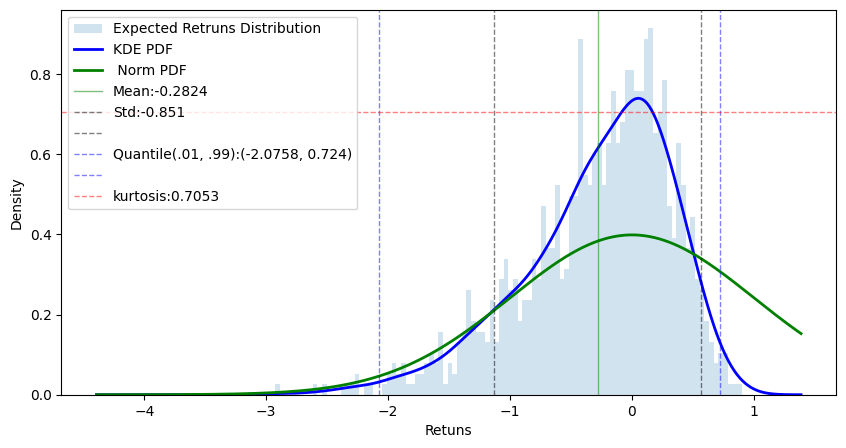

In [5]:
# plot distribution with pdf
ax = pd.DataFrame(y).plot(kind="hist",density=True, bins=100, alpha=0.2)
ax.plot(x, kde_pdf, 'b-', lw=2)
ax.plot(x, norm_pdf, 'g-', lw=2)

ax.axvline(mean, color='g', linestyle='-',  lw=1, alpha=0.5)
ax.axvline(mean+std, color='k', linestyle='--',  lw=1, alpha=0.5)
ax.axvline(mean-std, color='k', linestyle='--', lw=1, alpha=0.5)

ax.axvline(rv.ppf(0.01), color='b', linestyle='--',  lw=1, alpha=0.5)
ax.axvline(rv.ppf(0.99), color='b', linestyle='--', lw=1, alpha=0.5)
ax.axhline(kurtosis, color='r', linestyle='--', lw=1, alpha=0.5 )



ax.legend([
    "Expected Retruns Distribution", "KDE PDF", " Norm PDF", 
    f"Mean:{round(mean,4)}", f"Std:{round(std,4)}", None, 
    f"Quantile(.01, .99):{round(rv.ppf(0.01),4), round(rv.ppf(0.99),4)}",None,
    f"kurtosis:{round(kurtosis,4)}"
          ])

ax.set_xlabel("Retuns")
ax.set_ylabel("Density")

## Sample

In the above graph shows asset returns distribution and estimation of the PDF with KDE - Kernel Dense Estimation. 
It can be seen that the returns distribution is left skewed (losses might be quite huge). Also it is obvious that the
normal distribution is not able to describe the shape of the returns. Hense the KDE function is used.

In Order to build a random process with the same properties as the original (asset returns) we need to take into account the characterestics of  the first (mean, std, ....).

One of the possible approaches is to transform the estimated KDE function to CDF - Cumulated Density Function. This approach will allow us to sample from uniform distribution ([0..1]) and to translate these samples to random time series which same properties like our original asset returns time series.

First lets take a look on the Cumulated Density function:

### CDF - Cumulated Density Function
---

In [6]:
# build cdf which summarizes the previously created KDE density function 
cdf = np.vectorize(lambda x: kde_rv.integrate_box_1d(-np.inf, x))

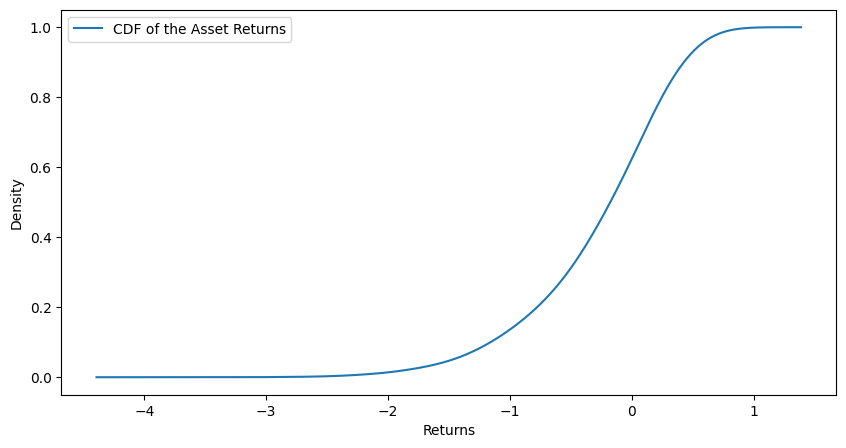

In [7]:
# plot cdf
ax = pd.DataFrame(
    {
        'x': x, 
        'pdf': cdf(x)
    }).plot(x='x',y='pdf')

ax.set_xlabel("Returns")
ax.set_ylabel("Density")
ax.legend(["CDF of the Asset Returns"])

### Sampling random returns
---


The CDF maps returns(x) to density(y). The range of density is [0...1] and allows as to randomly sample from the [0..1] space and hence to generate random asset returns which are inherent to our asset.

This projection will be accomplished by the following code. First we define numppy 2d array with y and y values

In [8]:
# create array which maps density to returns
np_cdf = np.column_stack(
    (
        cdf(x),
        x
    ))
np_cdf

array([[ 6.37082805e-25, -4.39163848e+00],
       [ 9.16031916e-25, -4.38585450e+00],
       [ 1.31526983e-24, -4.38007052e+00],
       ...,
       [ 9.99998466e-01,  1.37498942e+00],
       [ 9.99998662e-01,  1.38077340e+00],
       [ 9.99998835e-01,  1.38655738e+00]])

The actual function, which is vector based looks as following:

In [9]:
def sample_from_cdf(np_uniform:np.array, np_cdf:np.array):

    def get_reward(value: np.array) -> float:
        global np_cdf
        return np_cdf[np.abs(np_cdf[:, 0] - value).argmin()][1].astype(float)

    return np.array(list(map(get_reward, np_uniform)))

As mentioned before, this approach samples from [0..1] space

In [10]:
# lets generate 100000 samples
sample_dist = sample_from_cdf(
    np_uniform=np.random.uniform(size=100000),
    np_cdf=np_cdf
)
#sample_dist

The generated random time series should posses same characteristics like the origin asset returns distribution

Text(0, 0.5, 'Density')

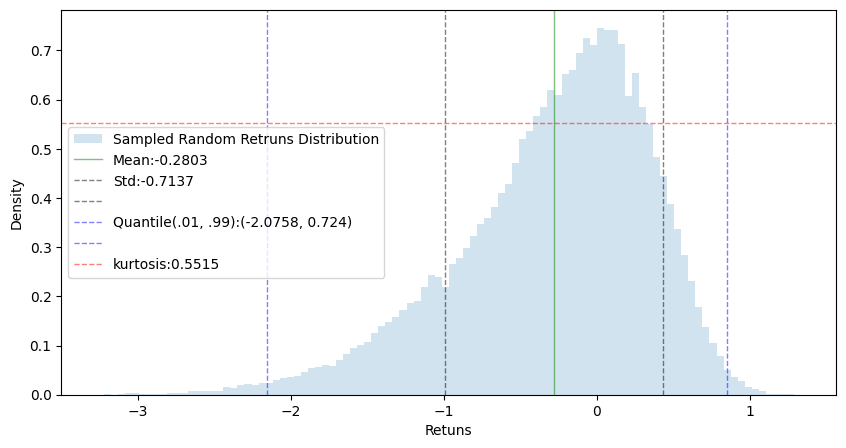

In [11]:
sample_rv = rv_histogram(np.histogram(sample_dist))
mean, var, std, kurtosis = sample_rv.stats(moments='mvsk')

# plot
ax = pd.DataFrame(sample_dist).plot(kind="hist", bins=100, density=True, alpha=.2)

ax.axvline(mean, color='g', linestyle='-',  lw=1, alpha=0.5)
ax.axvline(mean+std, color='k', linestyle='--',  lw=1, alpha=0.5)
ax.axvline(mean-std, color='k', linestyle='--', lw=1, alpha=0.5)

ax.axvline(sample_rv.ppf(0.01), color='b', linestyle='--',  lw=1, alpha=0.5)
ax.axvline(sample_rv.ppf(0.99), color='b', linestyle='--', lw=1, alpha=0.5)
ax.axhline(kurtosis, color='r', linestyle='--', lw=1, alpha=0.5 )



ax.legend([
    "Sampled Random Retruns Distribution", 
    f"Mean:{round(mean,4)}", f"Std:{round(std,4)}", None, 
    f"Quantile(.01, .99):{round(rv.ppf(0.01),4), round(rv.ppf(0.99),4)}",None,
    f"kurtosis:{round(kurtosis,4)}"
          ])

ax.set_xlabel("Retuns")
ax.set_ylabel("Density")

The showed code examples allow us to generate artificial time series upon the original (real) retuns data

This randomly generated time series gives us the ubililty to test our assumptions about the underling asset in simulations and model trainings.

Next step would be to use this sampling approach in connection with geometric brownian motion.